In [ ]:
! pip install -q kaggle

In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!rm kaggle.json

In [2]:
!kaggle datasets download -d rounakbanik/the-movies-dataset

100% 227M/228M [00:02<00:00, 115MB/s] 
100% 228M/228M [00:02<00:00, 107MB/s]


In [3]:
!unzip the-movies-dataset.zip -d dataset

Archive:  the-movies-dataset.zip
  inflating: dataset/credits.csv     
  inflating: dataset/keywords.csv    
  inflating: dataset/links.csv       
  inflating: dataset/links_small.csv  
  inflating: dataset/movies_metadata.csv  
  inflating: dataset/ratings.csv     
  inflating: dataset/ratings_small.csv  


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load Data

In [5]:
metadata = pd.read_csv("dataset/movies_metadata.csv")
metadata = metadata[["genres", "overview"]]
metadata['genres'] = metadata['genres'].apply(lambda x: re.findall("'name': '(\w*)'", x))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
metadata.isna().sum()

genres        0
overview    954
dtype: int64

In [7]:
metadata = metadata.dropna().reset_index()
metadata.isna().sum()

index       0
genres      0
overview    0
dtype: int64

In [8]:
metadata

,index,genres,overview
0,0,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ..."
1,1,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...
2,2,"[Romance, Comedy]",A family wedding reignites the ancient feud be...
3,3,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom..."
4,4,[Comedy],Just when George Banks has recovered from his ...
...,...,...,...
44507,45461,"[Drama, Family]",Rising and falling between a man and woman.
44508,45462,[Drama],An artist struggles to finish his work while a...
44509,45463,"[Action, Drama, Thriller]","When one of her hits goes wrong, a professiona..."
44510,45464,[],"In a small town live two brothers, one a minis..."


# Create target dataframe y
In this part I'm trying to create a dataframe with geners as columns. 

In [9]:
allGenres = set(metadata['genres'].sum())
y = pd.DataFrame(np.zeros((metadata.shape[0], len(allGenres))), columns=allGenres)
y['genres'] = metadata['genres']
def assignGenresToMoviess(item):
  item[item['genres']] = 1
  return item
y = y.apply(assignGenresToMoviess, axis=1).drop(['genres'], axis=1)

In [10]:
y

,Family,Comedy,Music,History,War,Fantasy,Adventure,Documentary,Animation,Crime,Romance,Drama,Mystery,Western,Thriller,Foreign,GoHands,Horror,Action,Aniplex
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44507,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
44510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Create features dataframe X

In [11]:
X = pd.DataFrame(metadata["overview"])
swords = stopwords.words('english') + ['a', 'an',]

stemmer = PorterStemmer()

def removeStopWords(item):
  words = re.sub("[^\w]", " ",  item).split()
  tokenized = [stemmer.stem(w.lower()) for w in words if w.lower() not in swords]
  return " ".join(tokenized)
X['stopwords'] = X['overview'].apply(removeStopWords)

In [12]:
vectorizer = CountVectorizer(ngram_range=(1, 1), max_features=1000)
veclist = vectorizer.fit_transform(X['stopwords'])
vectorizer.get_feature_names()

['000',
 '10',
 '20',
 '30',
 'abandon',
 'abl',
 'abus',
 'accept',
 'accid',
 'accident',
 'account',
 'accus',
 'across',
 'act',
 'action',
 'activ',
 'actor',
 'actress',
 'actual',
 'adapt',
 'addict',
 'adopt',
 'adult',
 'adventur',
 'affair',
 'affect',
 'age',
 'agent',
 'ago',
 'agre',
 'aid',
 'air',
 'alcohol',
 'alex',
 'alien',
 'aliv',
 'allow',
 'almost',
 'alon',
 'along',
 'alreadi',
 'also',
 'although',
 'alway',
 'america',
 'american',
 'among',
 'amp',
 'ancient',
 'angel',
 'anim',
 'ann',
 'anna',
 'anoth',
 'answer',
 'anyth',
 'apart',
 'appear',
 'approach',
 'area',
 'arm',
 'armi',
 'around',
 'arrest',
 'arriv',
 'art',
 'artist',
 'ask',
 'aspir',
 'assassin',
 'assign',
 'assist',
 'attack',
 'attempt',
 'attend',
 'attent',
 'attract',
 'audienc',
 'author',
 'avoid',
 'award',
 'away',
 'babi',
 'back',
 'bad',
 'band',
 'bank',
 'bar',
 'base',
 'battl',
 'beach',
 'bear',
 'beauti',
 'becam',
 'becom',
 'befriend',
 'begin',
 'behind',
 'believ',
 

# Model training

In [13]:
X_train, X_test, y_train, y_test = train_test_split(veclist, y, test_size=0.1, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40060, 1000)
(4452, 1000)
(40060, 20)
(4452, 20)


In [14]:
model = keras.Sequential(
    [
        layers.Dense(512, activation="ReLU", input_dim=X_train.shape[1]),
        layers.Dense(512, activation="ReLU"),
        layers.Dense(512, activation="ReLU"),
        layers.Dense(512, activation="ReLU"),
        layers.Dense(512, activation="ReLU"),
        layers.Dense(512, activation="ReLU"),
        layers.Dense(512, activation="ReLU"),
        layers.Dense(y_train.shape[1], activation="sigmoid")
    ]
)
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               512512    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 512)               2

In [15]:
history = model.fit(
    X_train.toarray(), y_train.values,
    batch_size=1000,
    epochs=200,
    )

Epoch 1/200
41/41 [==============================] - 4s 17ms/step - loss: 0.3217 - accuracy: 0.1830
Epoch 2/200
41/41 [==============================] - 1s 16ms/step - loss: 0.2632 - accuracy: 0.1759
Epoch 3/200
41/41 [==============================] - 1s 16ms/step - loss: 0.2569 - accuracy: 0.1752
Epoch 4/200
41/41 [==============================] - 1s 15ms/step - loss: 0.2378 - accuracy: 0.1966
Epoch 5/200
41/41 [==============================] - 1s 15ms/step - loss: 0.2143 - accuracy: 0.2849
Epoch 6/200
41/41 [==============================] - 1s 15ms/step - loss: 0.1887 - accuracy: 0.3438
Epoch 7/200
41/41 [==============================] - 1s 15ms/step - loss: 0.1609 - accuracy: 0.3859
Epoch 8/200
41/41 [==============================] - 1s 15ms/step - loss: 0.1376 - accuracy: 0.4235
Epoch 9/200
41/41 [==============================] - 1s 15ms/step - loss: 0.1190 - accuracy: 0.4559
Epoch 10/200
41/41 [==============================] - 1s 15ms/step - loss: 0.1037 - accuracy: 0.4800

140/140 [==============================] - 1s 4ms/step - loss: 1.1725 - accuracy: 0.2864
1.1725107431411743 0.2863881289958954


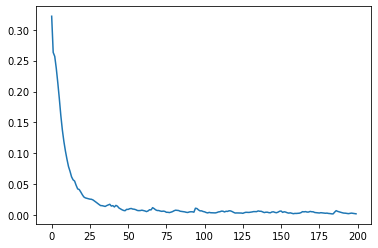

In [16]:
history_df = pd.DataFrame(history.history)
history_df['loss'].plot()
loss, acc = model.evaluate(X_test.toarray(), y_test.values)
print(loss, acc)